In [1]:
import os
import gc
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn 
from torch.cuda import amp
from torchmetrics import MeanMetric

from inferenceLogger import InferenceLogger
from uNetManager import UNetManager
from utils1 import get_default_device, get
from utils2 import visualize_data
from dataLoader import get_dataloader

In [ ]:
#todo build swiss roll distribution model
#todo forward_diffusion visualisation
#todo refactor SimpleDiffusion

In [15]:
BaseConfig = {
    'DEVICE' : get_default_device(),
    'DATASET' : "MNIST", #  "MNIST", "Cifar-10", "Cifar-100", "Flowers" ...
}

TrainingConfig = {
    'TIMESTEPS' : 500, # Define number of diffusion timesteps
    'NUM_EPOCHS' : 200,
    'BATCH_SIZE' : 256,#32 #amound of batches to divide the images into
    'LR' : 2e-4,
    'NUM_WORKERS' : 0 # does not work for windows
}    
    
ModelConfig = {
    'IMG_SHAPE' : (1, 32, 32) if BaseConfig['DATASET'] == "MNIST" else (3, 32, 32), 
    'BASE_CH' : 64,  # 64, 128, 256, 256
    'BASE_CH_MULT' : (1, 2, 4, 8) if BaseConfig['DATASET'] == "MNIST" else (1, 2, 4, 4) ,
    'APPLY_ATTENTION' : (False, True, True, False),
    'DROPOUT_RATE' : 0.1,
    'TIME_EMB_MULT' : 4 # 128
}

Total available data: 60000 Images / 234.38 MB 


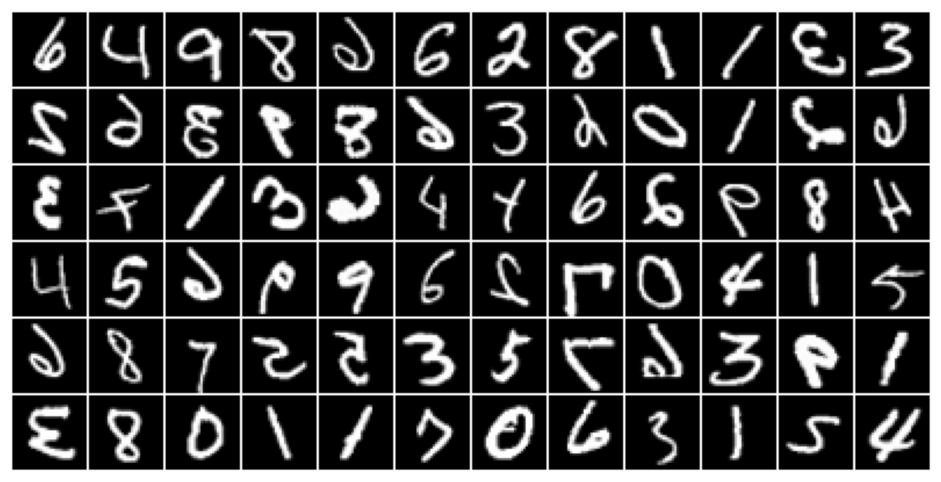

In [3]:
visualize_data(dataset_name=BaseConfig['DATASET'], amount=72)

In [5]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
        
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
         
    def get_betas(self):
        # linear schedule
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
    

$$
\Large x_t = \sqrt{\bar a_t}x_0 + \sqrt{1-\bar a_t}\epsilon
$$

In [6]:
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    # Noise
    e = torch.randn_like(x0)  
    # image scaled + noise scaled
    x_t  = (get(sd.sqrt_alpha_cumulative, t=timesteps) * x0 + 
               get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) * e)

    # return corrupted input and the corresponding noise applied
    return x_t, e   

![](.\resources\training.png)

In [7]:
# Algorithm 1: Training

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, 
                   base_config=BaseConfig, training_config=TrainingConfig):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config['NUM_EPOCHS']}")
    
        for x0s, _ in loader:
            tq.update(1)
            ts = torch.randint(low=1, high=training_config['TIMESTEPS'], size=(x0s.shape[0],), device=base_config['DEVICE'])
            xts, gt_noise = forward_diffusion(sd, x0s, ts)
            
            with amp.autocast():
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)
                
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

![](.\resources\sampling.png)

In [8]:
# generates "num_images"-amount of samples
    
@torch.no_grad()
def generate_samples(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, device="cpu", inference_logger=None):

    #1: x_T ~ N(0,1)
    # (actually in multiples: x := [x1_T, x2_T ..., x(num_images)_T] )
    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    #2: for t = T, ... ,1 do
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        #3: z ~ N(0,1) if t > 0, else z = 0
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        predicted_noise = model(x, ts)
        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        #4: x_{t-1} = ...
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        inference_logger.update(x)

    #6: return x_0
    inference_logger.save_result(x)

In [16]:
m = UNetManager(model_name="myDdpm", model_config=ModelConfig, checkpoint_name=None)
model = m.get_model()
model.to(BaseConfig['DEVICE'])

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig['LR'])
loss_fn = nn.MSELoss()
scaler = amp.GradScaler()

dataloader = get_dataloader(dataset_name=BaseConfig['DATASET'],
                            batch_size=TrainingConfig['BATCH_SIZE'],
                            num_workers=TrainingConfig['NUM_WORKERS'],
                            device=BaseConfig['DEVICE'])

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig['TIMESTEPS'],
    img_shape               = ModelConfig['IMG_SHAPE'],
    device                  = BaseConfig['DEVICE'],
)


models\myDdpm\config.json is used instead.
Total available data: 60000 Images / 234.38 MB 


In [ ]:
generate_video = True
ext = ".mp4" if generate_video else ".png"

for epoch in range(1, TrainingConfig['NUM_EPOCHS'] + 1):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)
    
    if epoch % 20 == 0:
        #todo save_path = os.path.join(log_dir, f"{epoch}{ext}")
        save_path = "models/myDdpm/inference_logs"
        #todo generate_video = yes/no/off
        
        # Algorithm 2: Sampling
        generate_samples(
            model, sd, timesteps=TrainingConfig['TIMESTEPS'], num_images=1,
            inference_logger=InferenceLogger(generate_video, save_path),img_shape=ModelConfig['IMG_SHAPE'], device=BaseConfig['DEVICE'],
        )
        
        m.update_checkpoint(optimizer, scaler, model)

In [19]:
m.update_checkpoint(optimizer,scaler,model)

new checkpoint created at: models\myDdpm\checkpoints\ckpt.tar


# Inference

In [20]:
log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

Sampling :: 100%|██████████| 449/449 [01:41<00:00,  4.43it/s]


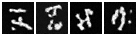

inference_results\20240628-203206.mp4


In [24]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

generate_samples(
    model,
    sd,
    num_images=4,#16,
    inference_logger=InferenceLogger(generate_video, save_path, nrow=4),
    timesteps=500,
    img_shape=ModelConfig['IMG_SHAPE'],
    device=BaseConfig['DEVICE'],
)
print(save_path)